<center><h1>Predykcja ceny</h1></center>


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as ls
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
import seaborn as sns


In [20]:

data = pd.read_csv('data/raw_data/zal_hausing.csv')
data = data.drop(columns=['zainter'])
print(data.head().to_string())

   pietro  izby  powierzchnia  zadrzewienie   autostrada   przemysł     centrum     jezioro        lasy     tramwaj     policja      szkola     cena
0       0     4         65.10         13.44   3153.81100   63.63961  7366.52600  1384.37700   538.56290   472.70500  2996.06800  1324.84000  4531.49
1       3     2         32.70         21.56   8452.07227  134.35030  2818.24414  1601.85046  1471.20703    96.04687  1860.02686   289.87067  1972.32
2       0     3         40.98          1.20   6571.53900   89.44272  2269.05800  1264.80200   798.82730    40.31129   734.20030   261.72500  2037.58
3       3     2         49.53          0.48  11763.63574  207.00241  5615.26953  5416.94092   236.48466  2214.45825  2338.56787   182.48288  5471.43
4       4     3         81.40         21.72   4384.95500  169.18920  2375.39500  3475.80900  2024.84600   317.56890  1301.76800    65.00000  3482.80


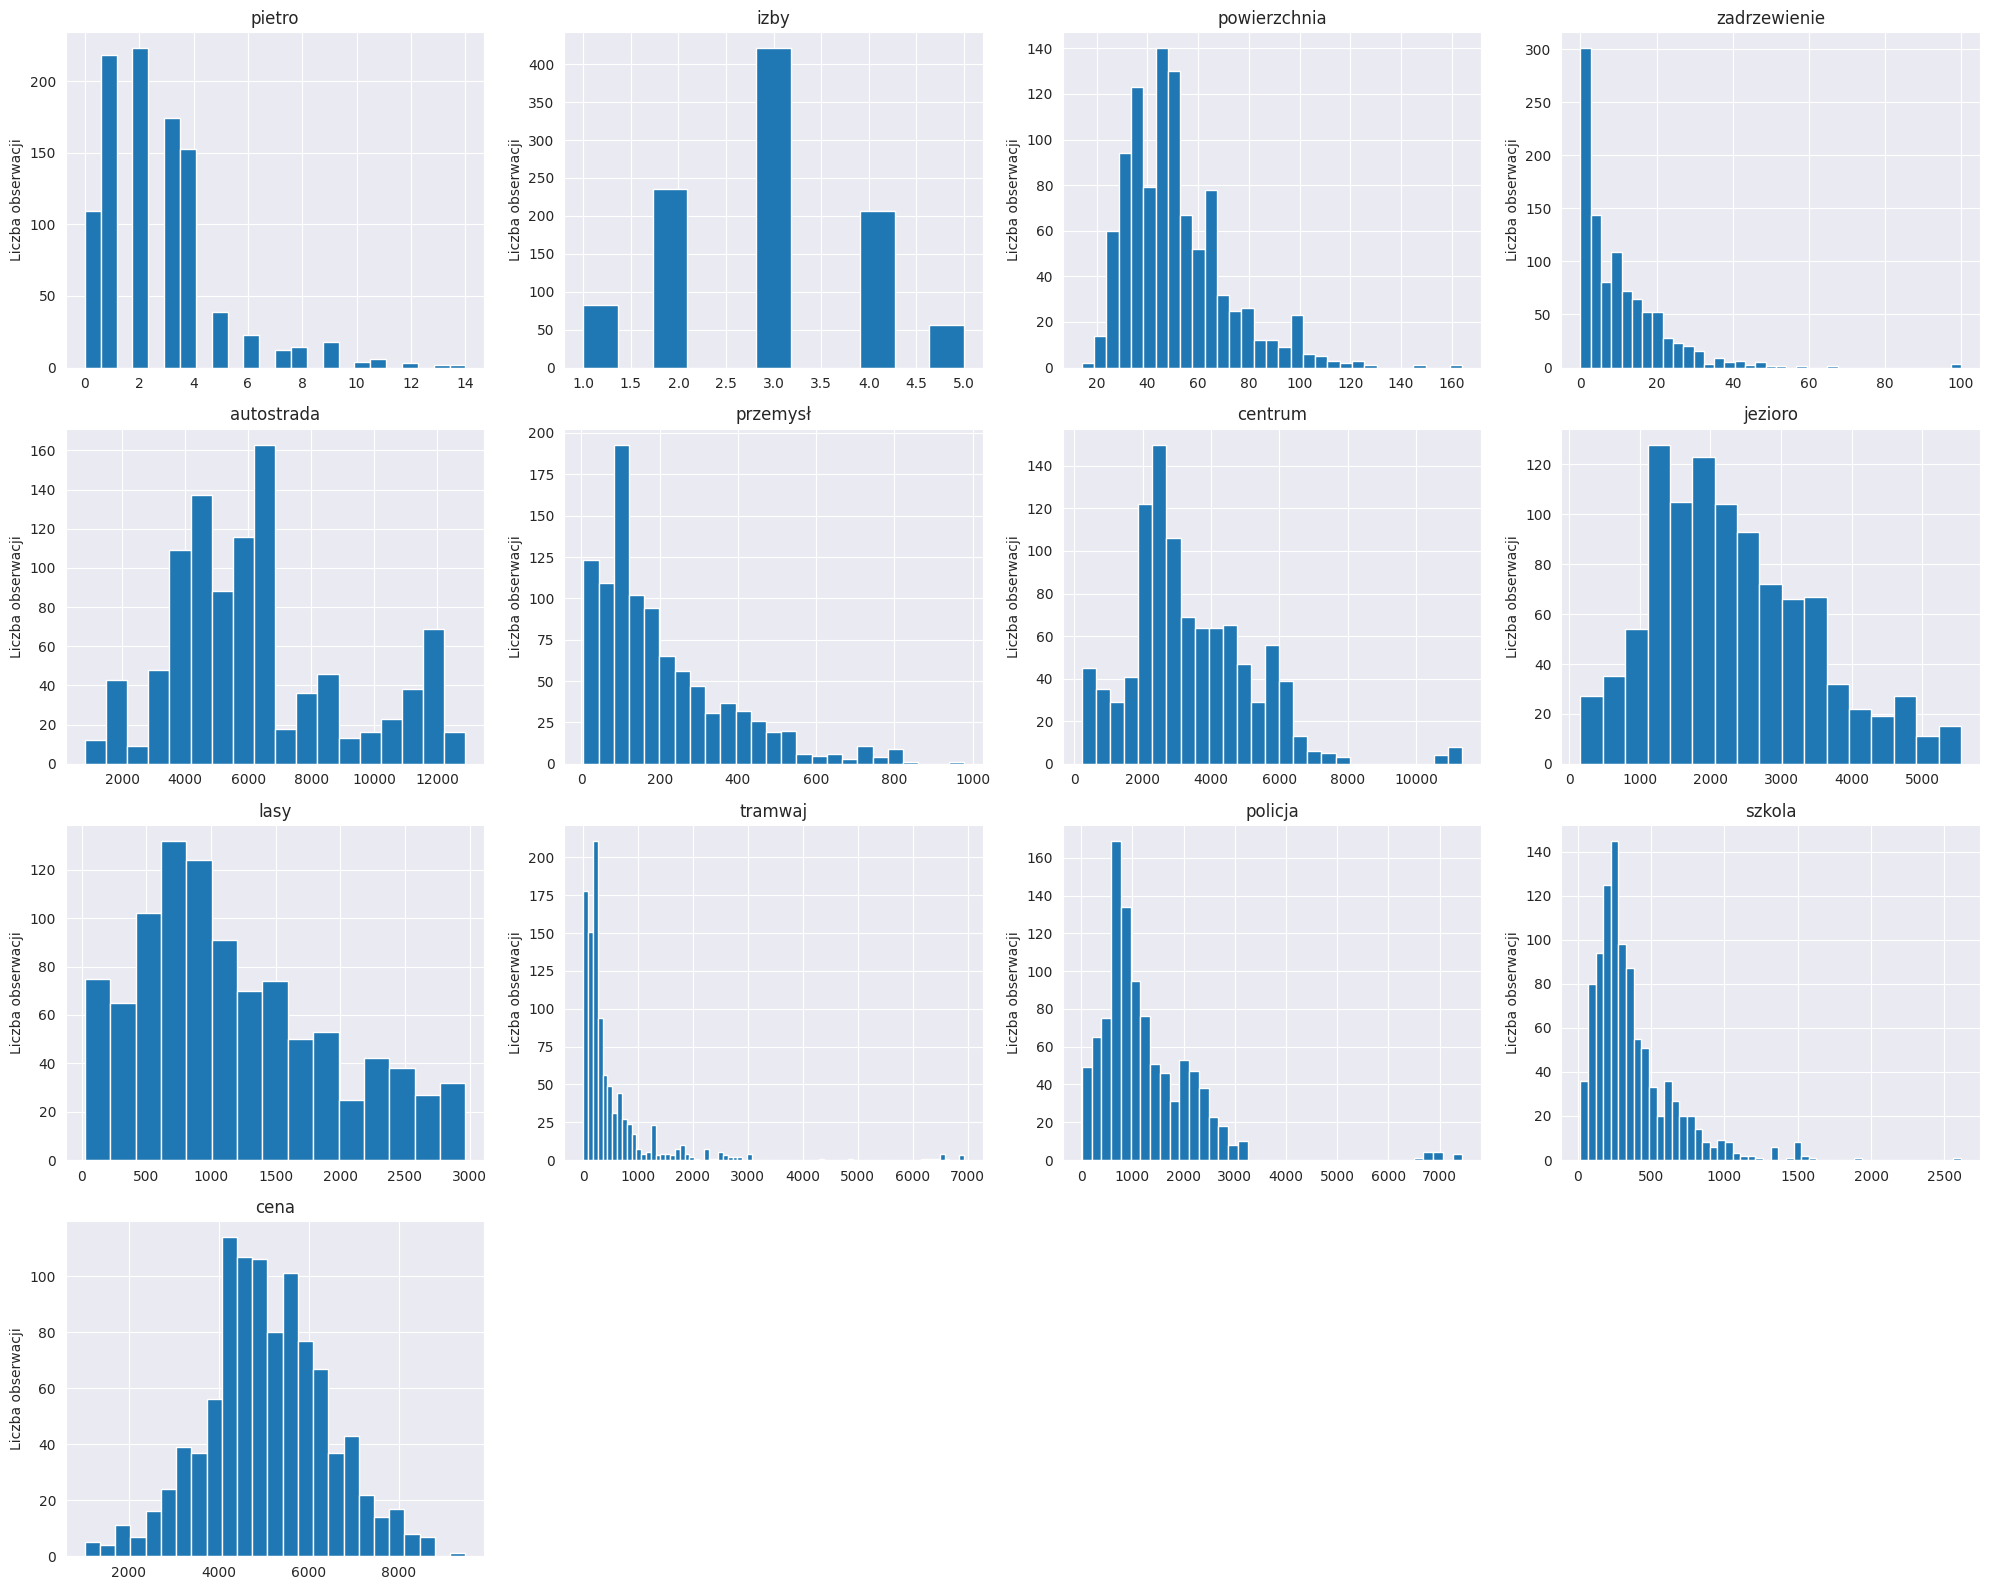

In [21]:

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    axes[i].hist(data[column].dropna(), bins='auto')
    axes[i].set_title(column)
    axes[i].set_ylabel("Liczba obserwacji")

for j in range(13, 16):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


MAPE: 22.99%


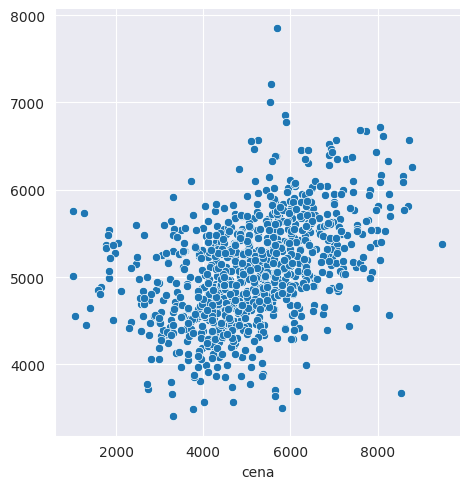

In [22]:

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

model_o = ls().fit(X, y)

yhat = model_o.predict(X)

sns.relplot(x=y,y=yhat)

Zmienne nie zostały przeskalowane. Model nie jest dobrze dopasowany. Jest nieznaczna korelacja  między $y$ a $\hat{y}$

MAPE: 201.68%


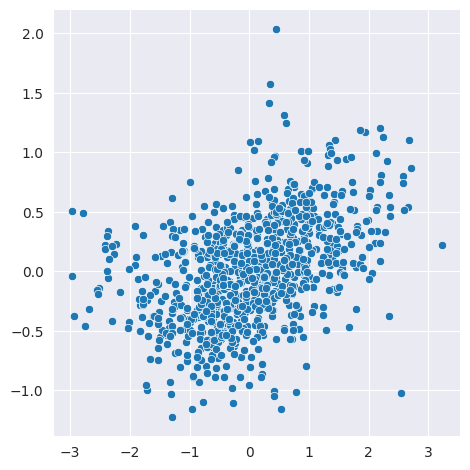

In [23]:

scaler = StandardScaler().fit(data)
scaled = scaler.transform(data)
X = scaled[:,:-1]
y = scaled[:,-1]
model_s = ls().fit(X,y)
yhat = model_s.predict(X)
sns.relplot(x=y,y=yhat)


Skalowanie niewiele pomogło, dalej nie ma znaczącej korelacji.

MAPE 256.04%


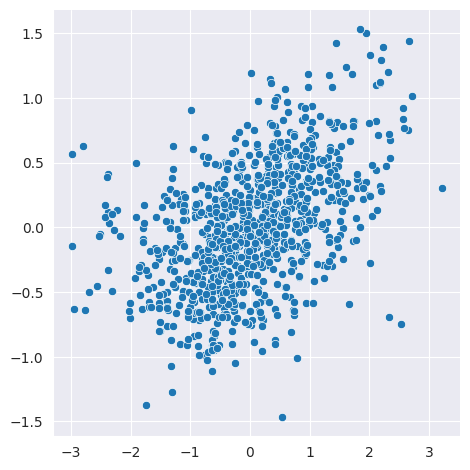

In [24]:

transformer_p = PowerTransformer().fit(data)
transformed = transformer_p.transform(data)
X = transformed[:,:-1]
y = transformed[:,-1]
model_p = ls().fit(X,y)
yhat = model_p.predict(X)
sns.relplot(x=y,y=yhat)

MAE: 0.20607738522077101


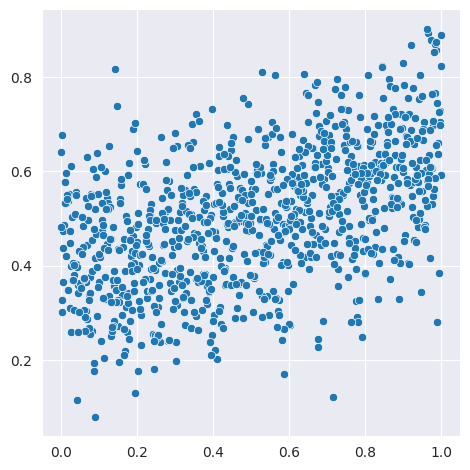

In [25]:
transformer_q = QuantileTransformer().fit(data)
transformed = transformer_q.transform(data)
X = transformed[:,:-1]
y = transformed[:,-1]
model_q = ls().fit(X,y)
yhat = model_q.predict(X)
sns.relplot(x=y,y=yhat)


In [26]:
coefs = pd.DataFrame((model_o.coef_,model_s.coef_,model_p.coef_,model_q.coef_),columns=data.columns[:-1])
coefs = coefs.T
coefs.columns=["Ord","scaled","GLS-YJ", "GLS-Q"]
coefs

,Ord,scaled,GLS-YJ,GLS-Q
pietro,-29.312115,-0.047814,-0.028141,-0.036650
izby,-187.251246,-0.136383,-0.096654,-0.103418
powierzchnia,-9.762576,-0.141210,-0.188208,-0.213436
zadrzewienie,-14.176849,-0.116925,-0.157391,-0.186083
autostrada,0.069186,0.141327,0.070172,0.083430
przemysł,1.039137,0.130839,0.186727,0.186273
centrum,-0.003658,-0.004837,-0.078649,0.093465
jezioro,-0.157398,-0.131396,-0.115366,-0.137458
lasy,0.072115,0.039111,0.020551,0.140957
tramwaj,0.019204,0.012231,0.145458,0.090324


Analizując wartości współczynników modelu z przeskalowanymi danymi, można zauważyć, że istotne wydają się cechy Izby, powierzchnia, zadrzewienie oraz jeziora, których wzrost wartości obniża wartość predykcji ceny, oraz autostrada i przemysł, które ją zwiększają.

Transformacja potęgowa podnosi istotność powierzchni, zadrzewienia oraz przemysłu. Co ważne, znacznie zwiększyła istotność Tramwaju, który był pomijalny w modelu bez transformacji. Równiez zmienna centrum po transformacjach okazuje się istotniejsza.

Są niewielkie różnice między tranformacją kwantylową i potęgową. Jedyną istotną zmianą jest zwiększenie istotności Lasów przez transformacje kwantylową. Lasy były pomijalne zarówno w modelu bez transformacji jak i w potęgowej.

*Czy wszystkie zmienne wyjaśniające powinny być numeryczne?*


W rozpatrywanym modelu regresji liniowej każda zmienna musi byc numeryczna. Jeśli zachodzi potrzeba uwzględnienia zmiennej kategorycznej, to najlepiej zastosować one-hot encoding. Niestety wiąże się to ze zwiększeniem liczby wymiarów. Rozwiązaniem pośrednim mogłoby być zamiana kategorii na liczby całkowite, wiąże się to jednak z wieloma problemami. Niekoniecznie wzrost wartości zmiennej zawsze by zwiększał wartość predykcji albo zawsze ją zmniejszał. Podejście do problemu zależy od danych.

*Zmienne o małej przydatności dla modelu liniowego*

Zmienne pomijalne w modelu przed transformacjami to Tramwaj(0.01), Lasy(0.02), Piętro(-0.047) oraz Centrum(-0.004). Po tranformacji potęgowej mało przydatne są tylko Lasy(0.02) i Piętro(-0.028). Po tranformacji kwantylowej jedynie Piętro(-0.036).

In [27]:
from pygam import LinearGAM, s, f
from pygam import LogisticGAM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [28]:
np.int = np.int_
data = pd.read_csv('data/raw_data/zal_hausing.csv')
data = data.drop(columns=['zainter'])
data['izby'] = data['izby'] - 1
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [29]:
gam = LinearGAM(f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11), fit_intercept=True)

gam.fit(X, y)
gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    113.4321
Link Function:                     IdentityLink Log Likelihood:                                -14879.9374
Number of Samples:                         1000 AIC:                                            29988.7389
                                                AICc:                                           30018.6046
                                                GCV:                                           1449115.982
                                                Scale:                                        1156603.7382
                                                Pseudo R-Squared:                                   0.4486
Feature Function                  Lam

/tmp/ipykernel_4337/3424495904.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


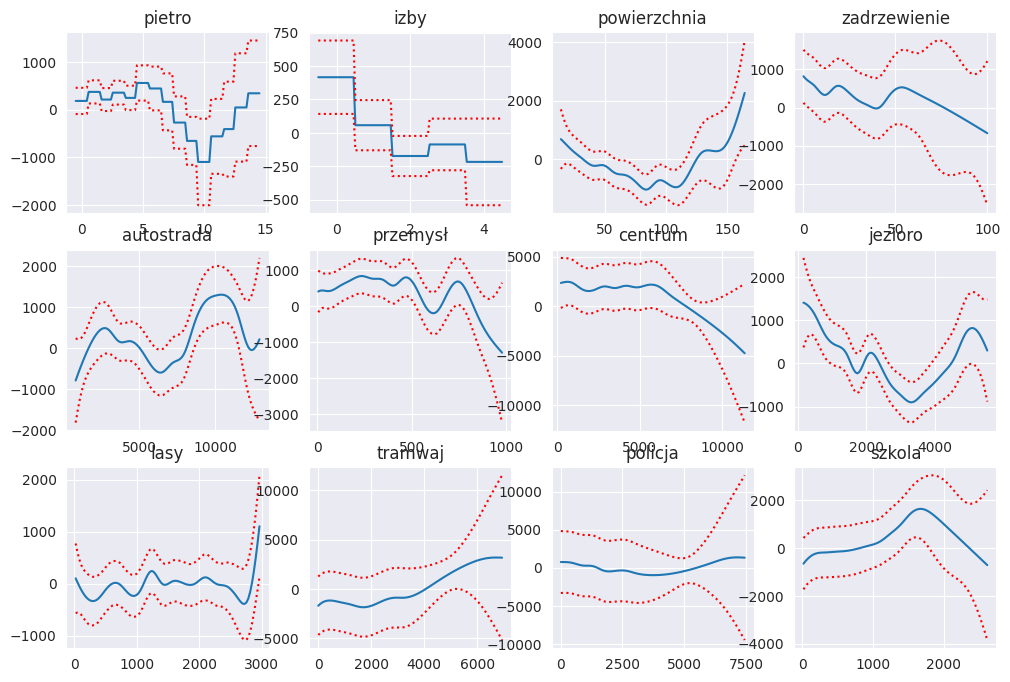

In [30]:
fig, axes = plt.subplots(3,4,figsize=(12,8))
for t, ax in zip(range(12),axes.flatten()):
    XX = gam.generate_X_grid(term=t)
    pdp, confi = gam.partial_dependence(term=t, X=XX, width=0.95)
    ax.plot(XX.T[t],pdp)
    ax.plot(XX.T[t],confi,c="r",ls=":")
    ax.set_title(X.columns[t])

Nieliniowa zależność między zmienną a wynikiem zauważalna jest dla cech: Piętro, Powierzchnia, Autostrada, Jezioro, Lasy.

Pozorna nieliniowość występuje dla cechy Szkoła. wynika ona raczej z małej liczby danych większych niż 1500.

Zmienna Autostrada dla wartości okolo 6500 obniża wartość predykcji, zmienia się to dla przedziałow bliższych 0 i większych niż 8000. Dla większych niż 10000 pozornie znowu zmniejsza wartość predykcji. wynika to jednak raczej z małej liczby obserwacji w tym przedziale.

Zmienna Powierzchnia znacznie zwiększa wartość predykcji gdy jej wartość przekracza 125.

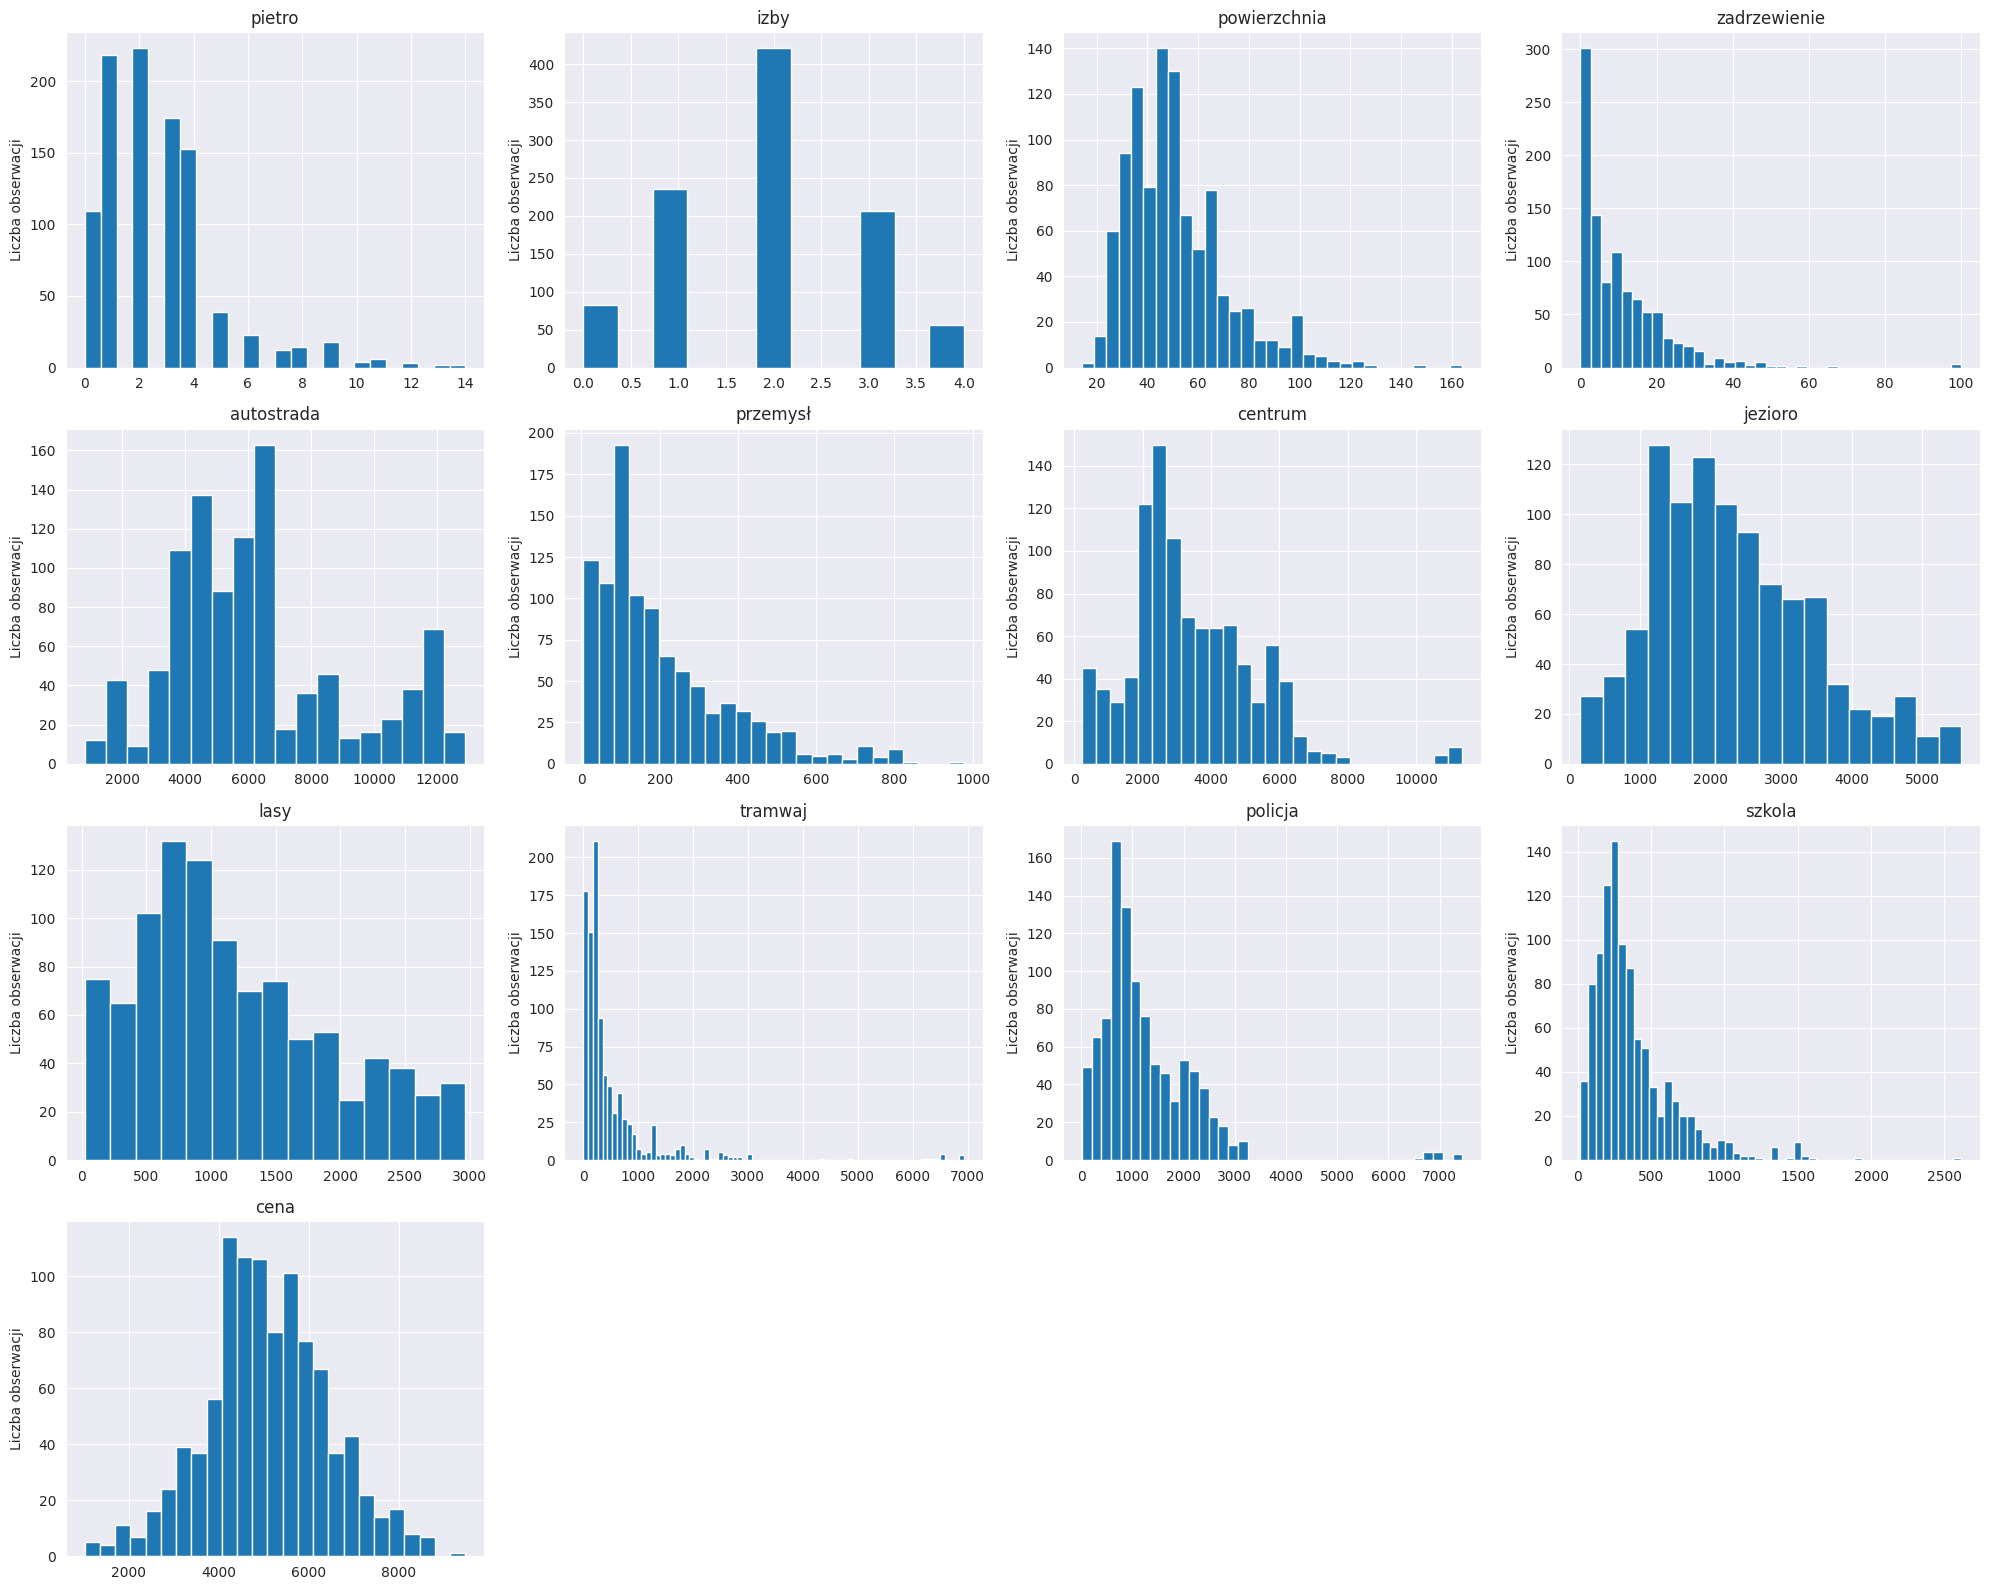

In [31]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    axes[i].hist(data[column].dropna(), bins='auto')
    axes[i].set_title(column)
    axes[i].set_ylabel("Liczba obserwacji")

for j in range(13, 16):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

<center><h1>Predykcja zainteresowania</h1></center>

In [32]:
data = pd.read_csv('data/raw_data/zal_hausing.csv')


   pietro  izby  powierzchnia  zadrzewienie   autostrada   przemysł     centrum     jezioro        lasy     tramwaj     policja      szkola     cena  zainter
0       0     4         65.10         13.44   3153.81100   63.63961  7366.52600  1384.37700   538.56290   472.70500  2996.06800  1324.84000  4531.49    False
1       3     2         32.70         21.56   8452.07227  134.35030  2818.24414  1601.85046  1471.20703    96.04687  1860.02686   289.87067  1972.32     True
2       0     3         40.98          1.20   6571.53900   89.44272  2269.05800  1264.80200   798.82730    40.31129   734.20030   261.72500  2037.58     True
3       3     2         49.53          0.48  11763.63574  207.00241  5615.26953  5416.94092   236.48466  2214.45825  2338.56787   182.48288  5471.43    False
4       4     3         81.40         21.72   4384.95500  169.18920  2375.39500  3475.80900  2024.84600   317.56890  1301.76800    65.00000  3482.80     True


Struktura danych jest identyczna jak w analizie predykcji ceny, etap ten więc pominę. Jedyną różnicą jest zmienna zainteresowanie.

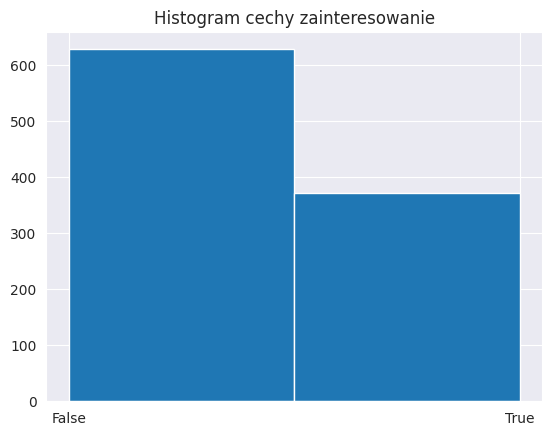

In [36]:
plt.hist(data['zainter'].astype(int), bins=2)
plt.xticks([0, 1], ['False', 'True'])
plt.title('Histogram cechy zainteresowanie')
plt.show()


In [48]:
from sklearn.linear_model import LogisticRegression

X = data.drop(columns=['zainter'])
y = data['zainter'].astype(int)

# --- 1. Surowe dane ---
model_raw = LogisticRegression(max_iter=1000)
model_raw.fit(X, y)
coefs_raw = model_raw.coef_[0]

# --- 2. Skalowanie StandardScaler ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model_scaled = LogisticRegression(max_iter=1000)
model_scaled.fit(X_scaled, y)
coefs_scaled = model_scaled.coef_[0]

# --- 3. Transformacja log1p ---
X_log = np.log1p(X)
model_log = LogisticRegression(max_iter=1000)
model_log.fit(X_log, y)
coefs_log = model_log.coef_[0]

# --- 4. Zbiorcza tabela ---
coef_table = pd.DataFrame({
    'cecha': X.columns,
    'coef_surowe': coefs_raw,
    'coef_skalowane': coefs_scaled,
    'coef_log1p': coefs_log
})

coef_table['|raw - scaled|'] = np.abs(coef_table['coef_surowe'] - coef_table['coef_skalowane'])
coef_table['|raw - log1p|'] = np.abs(coef_table['coef_surowe'] - coef_table['coef_log1p'])

coef_table = coef_table.sort_values(by='|raw - scaled|', ascending=False)

print(coef_table.to_string(index=False))


       cecha  coef_surowe  coef_skalowane  coef_log1p  |raw - scaled|  |raw - log1p|
        cena    -0.000986       -3.336789   -9.285422        3.335803       9.284436
        izby    -1.155709       -2.331743   -5.556443        1.176034       4.400733
powierzchnia     0.047038        0.779718    0.640220        0.732680       0.593182
     jezioro    -0.000283       -0.632782   -0.458265        0.632498       0.457982
     policja     0.000123       -0.609818   -0.295130        0.609941       0.295254
zadrzewienie    -0.011214       -0.424175   -0.184598        0.412962       0.173384
  autostrada     0.000236        0.387325    0.701259        0.387089       0.701023
    przemysł    -0.000528        0.357661    0.220318        0.358189       0.220846
     tramwaj    -0.000648        0.166679   -0.024718        0.167327       0.024070
        lasy     0.001576        0.163602   -0.017793        0.162026       0.019370
      pietro     0.064804        0.185082    0.259531        0.12

/home/jeku/Projects/Interpretacyjne-Uczenie-Maszynowe/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model z danymi nie przeskalowanymi nie osiąga zbieżności. Zarówno w modelu z danymi przeskalowanymi jak i transformowanymi głownie Cena wpływa na zainteresowanie. dziala ograniczająco. Drugą naistotniejszą cechą jest liczba Izb.

Mało istotne dla modelu przed tranformacja jak i po wydają się cechy Szkoła, Centrum, Piętro, Lasy oraz Tramwaj. Centrum nieznacznie jednak zyskuje po transformacji.

In [50]:
LE = LabelEncoder().fit(y)
y = LE.transform(y)
gam = LogisticGAM().fit(X,y)

/home/jeku/Projects/Interpretacyjne-Uczenie-Maszynowe/.venv/lib/python3.11/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/home/jeku/Projects/Interpretacyjne-Uczenie-Maszynowe/.venv/lib/python3.11/site-packages/pygam/pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2


In [51]:
yhat = gam.predict(X)
gam.accuracy(X,y)
proba = gam.predict_proba(X)

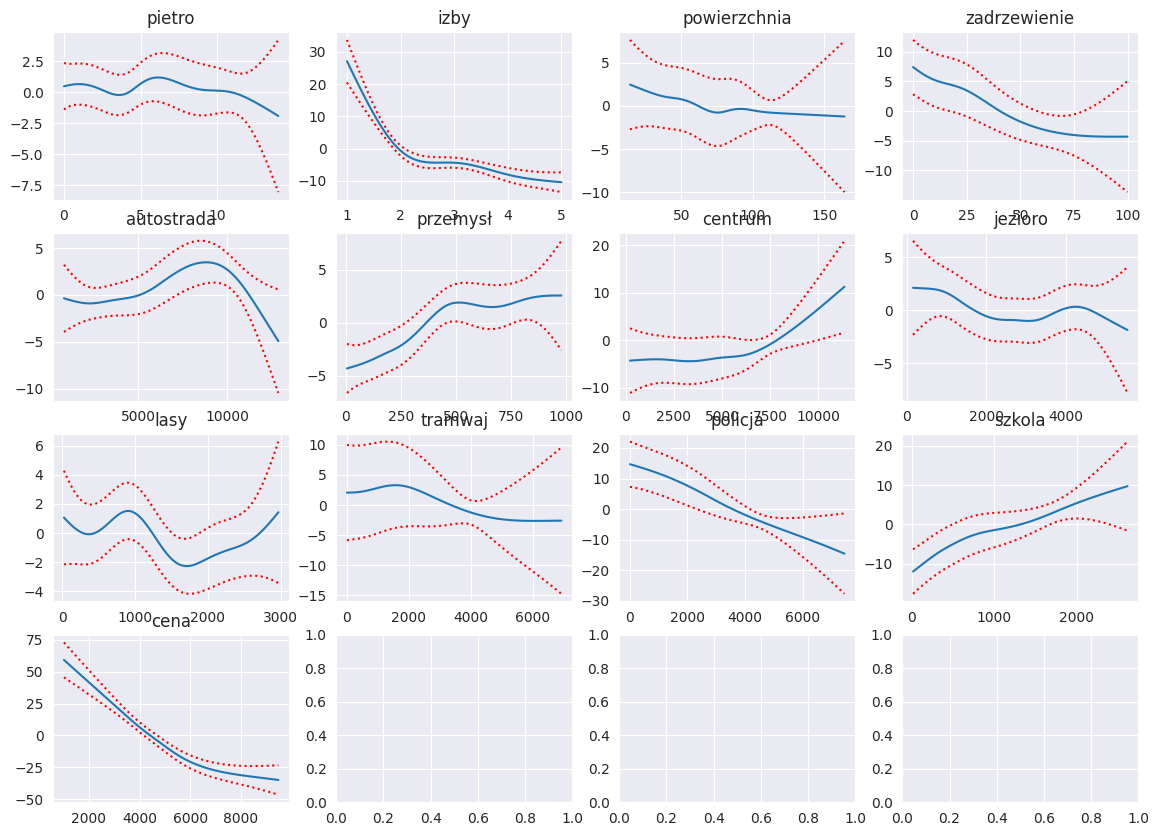

In [55]:
fig, axes = plt.subplots(4,4,figsize=(14,10))
for term, ax in zip(range(13),axes.flatten()):
    XX = gam.generate_X_grid(term=term)
    pdp, confi = gam.partial_dependence(term=term, X=XX, width=0.95)
    ax.plot(XX.T[term],pdp)
    ax.plot(XX.T[term],confi,c="r",ls=":")
    ax.set_title(X.columns[term])

Zmienne autostrada oraz lasy zachowują się nieliniowo. Autostrada dla wartości powyżej 8000 zaczyna obniżać wartość predykcji zainteresowania. Lasy dla wartości 1800 zaniżają najmocniej. okolo 1000 działają progresywnie na wartość predykcji. Nie wygląda, żeby wynikało to z samych danych, raczej z ich specyfiki. Granice przedziału ufności w rozpatrywanych zakresach nie odstają drastycznie.